##### Отправляем сообщения всегда, но узел может быть не активен (блокирован) тогда сообщение ставится в очередь на узел
##### после блокировки узел считается снова свободным если очередь < L*0,5
##### число узлов 300, поток ренерируется 150 шагов, плотность сети 3,54
MultiplierThresholdToBlock <strong>L 100</strong>, FractionThresholdToUnBlock 0,5, UseOnlyIsActiveNodes True, NumberOfGenerations 150 <br>


In [1]:
from matplotlib import pyplot as plt
import numpy as np
from datetime import datetime
import pandas as pd
import os
from labellines import labelLine, labelLines
  
log_dir_path = os.path.abspath('..\\..\\')+"\\Result"
numberOfGenerations = 150;
percolation = 0.34;
nodeCount=300;

files = [
    {"filename": "Netsim-Node-Metrics-queue-{log_tag}", "title": "Среднее число сообщений в очереди на узле на обработку", "ylabel":"Число сообщений" },
    {"filename": "Netsim-Node-Metrics-load-{log_tag}", "title": "Загрузка узлов", "ylabel":"Доля от производительности узла" },
    {"filename": "Netsim-Connection-Metrics-load-{log_tag}", "title": "Средняя загрузка связей", "ylabel":"Доля от производительности связи" },
    {"filename": "Netsim-Message-Metrics-failed-{log_tag}", "title": "Число потерянных сообщений", "ylabel":"Число сообщений" },
]

filesBlocked = [
    {"filename": "Netsim-Node-Metrics-blocked-{log_tag}", "title": "Доля блокированных узлов" },
]
filesInfected = [
    {"filename": "Netsim-Node-Metrics-IsInfected-{log_tag}", "title": "Доля инфицированных узлов" },
]

filesMessage = [
    {"filename": "Netsim-Message-Metrics-{log_tag}", "title": "Число доставленных сообщений с течением времени" },

]
summBlocked = pd.DataFrame();
summInfected = pd.DataFrame();
MessageResived = pd.DataFrame();
MessageFall = pd.DataFrame();
MessageTimeSpent = pd.DataFrame();
          
def load_csv_file(path):
    file = open(path)
    data = file.readlines()
    splitted_data = [x.split(',') for x in data]
    return splitted_data, len(splitted_data[0])


def aggeregate_line(array):
    aggregated = [sum([float(y) for y in x])/len(x) for x in array]
    return aggregated, len(aggregated)


def showStat():
    for file in files:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel(file['ylabel'])
        
        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line(data)
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label'])    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()
                                           
def get_xvals(lines):
    ax = lines[0].axes
    shrink_factor = 0.05
    xvals = ax.get_xlim()
    xvals_rng = xvals[1] - xvals[0]
    shrinkage = xvals_rng * shrink_factor
    xvals = (xvals[0] + shrinkage, xvals[1] - shrinkage)
    return xvals;
                                           
def get_x(xvals, i, count):
    h = (xvals[1] - xvals[0])/(count+1);
    return h*(i+1)+xvals[0];
                                           
                                           
def aggeregate_line_perc_node(array):
    aggregated = [sum([1 for y in x if float(y) > 0])/len(x) for x in array]
    return aggregated, len(aggregated)

def showStatInfected():
    for file in filesInfected:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля инфицированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            aggregated, count = aggeregate_line_perc_node(data)
            summ = np.sum(aggregated)
            summInfected.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()

def showStatBlocked():
    for file in filesBlocked:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.axhline(y=percolation, color='r', linestyle='-')
        plt.xlabel("Шаги")
        plt.ylabel("Доля блокированных узлов")

        for log_tag in log_tags:
            data, line_len = load_csv_file(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            dataI, line_lenI = load_csv_file(f"{log_dir_path}/{filesInfected[0]['filename'].format(log_tag = log_tag['tag'])}")
                                           
            aggregated, count = aggeregate_line_perc_node(data)
            aggregatedI, count = aggeregate_line_perc_node(dataI)
            aggregated = np.array(aggregated) - np.array(aggregatedI)
            summ = np.sum(aggregated)
            summBlocked.at[quantity, log_tag['label']] = summ/count;
            ax.plot(range(0, count), aggregated, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    showStatInfected();

def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

def load_csv_file_message(path):
    file = open(path)
    data = file.readlines()
    t = datetime(2021,6,1,1)
   
    splitted_data = [(str2bool(x.split(',')[-2]), (datetime.strptime(x.split(',')[-1], '%d.%m.%Y %H:%M:%S\n')-t).total_seconds(), float(x.split(',')[2]))  for x in data]
    df = pd.DataFrame(data=splitted_data,  columns=['Resived', 'Time' ,'TimeSpent']);
    total_count = len(df.index);
    timeSpent_avr = df['TimeSpent'].mean();
    df = df.loc[df['Resived'] == True]
    agg= df.groupby(['Time']).count()
    return agg['Resived'].to_numpy(), agg.index.get_level_values(0).to_numpy(), total_count, timeSpent_avr

def showStatMessage():
    for file in filesMessage:
        fig, ax = plt.subplots()
        plt.rcParams['figure.figsize'] = [10, 7]
        ax.set_title(file['title'])
        plt.axvline(x=numberOfGenerations, c="black")
        plt.xlabel("Шаги")
        plt.ylabel("Число сообщений")
       
        for log_tag in log_tags:
            data, line_len, all_count, timeSpent_avr = load_csv_file_message(f"{log_dir_path}/{file['filename'].format(log_tag = log_tag['tag'])}")
            summ = np.sum(data);
            fall = (all_count-summ)*100/all_count;
            print('Доставлено '+str(summ)+' Потеряно '+ "{:3.4f}".format(fall)+'% -'+log_tag['label']);
            
            MessageResived.at[quantity, log_tag['label']] = summ*100/all_count;
            MessageFall.at[quantity, log_tag['label']] = fall;
            MessageTimeSpent.at[quantity, log_tag['label']] = timeSpent_avr;
            ax.plot(line_len, data, c=log_tag['color'], label=log_tag['label']+' S='+str(summ))    
            legend = ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
            legend.get_frame()
    plt.show()


<strong>Поток Quantity 100 </strong>

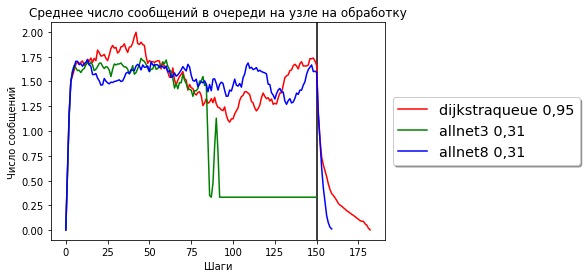

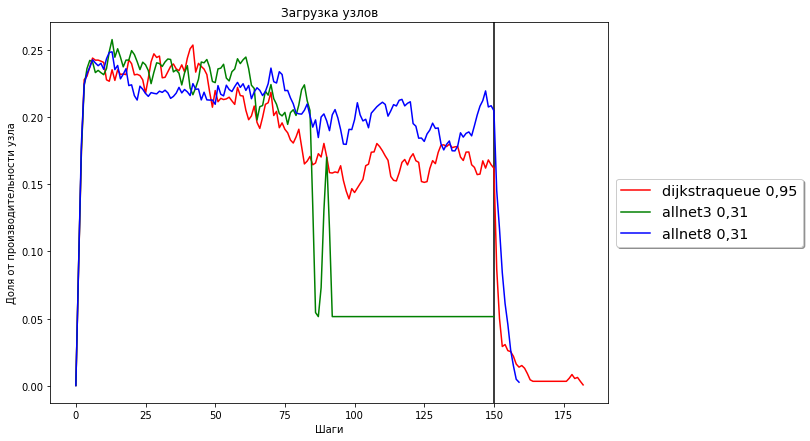

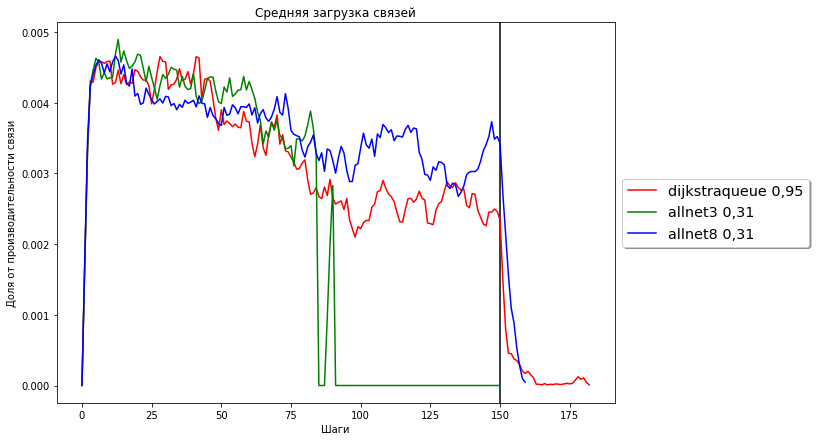

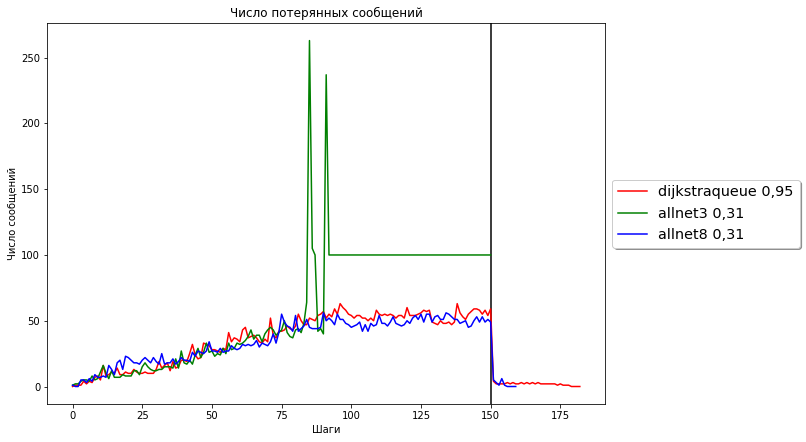

Доставлено 9353 Потеряно 37.6508% -dijkstraqueue 0,95
Доставлено 6317 Потеряно 57.8895% -allnet3 0,31
Доставлено 9668 Потеряно 35.5510% -allnet8 0,31


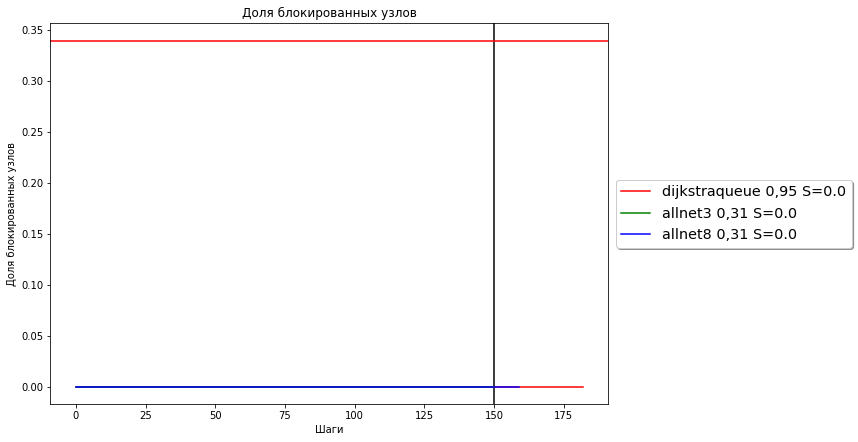

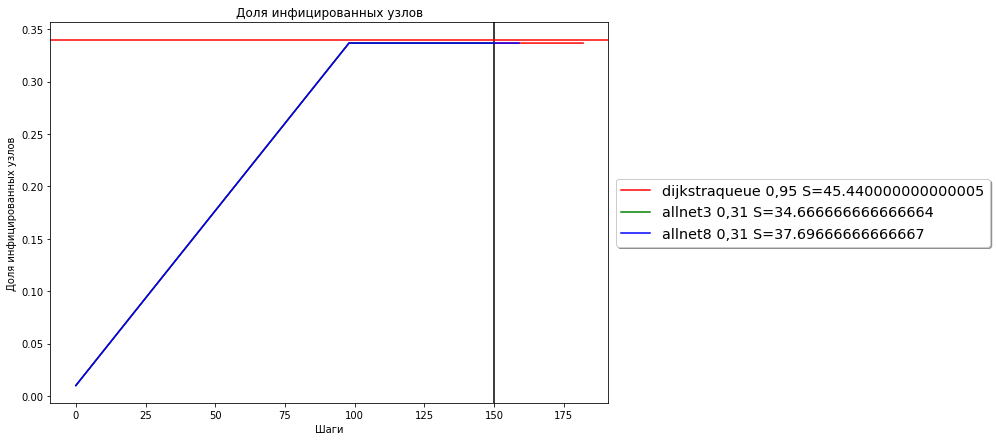

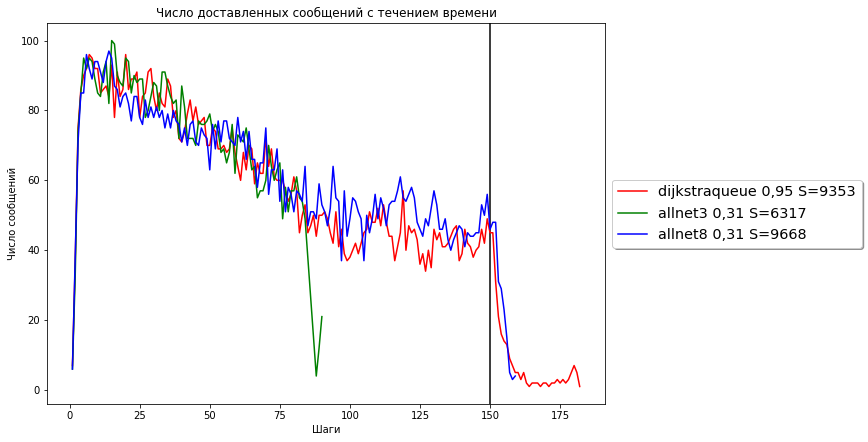

In [2]:
quantity = 100;
log_tags = [
{"tag":  "1220b458-9f0f-4cdb-8660-ba7c075b2b52", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "7499549b-af20-4a6a-95d2-8b881ad2e2d6", "label": "allnet3 0,31", "color": "green"},
{"tag":  "0aa9336b-bfc2-4b75-a497-fee450c330c3", "label": "allnet8 0,31", "color": "blue"},
]                         
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 500 </strong>

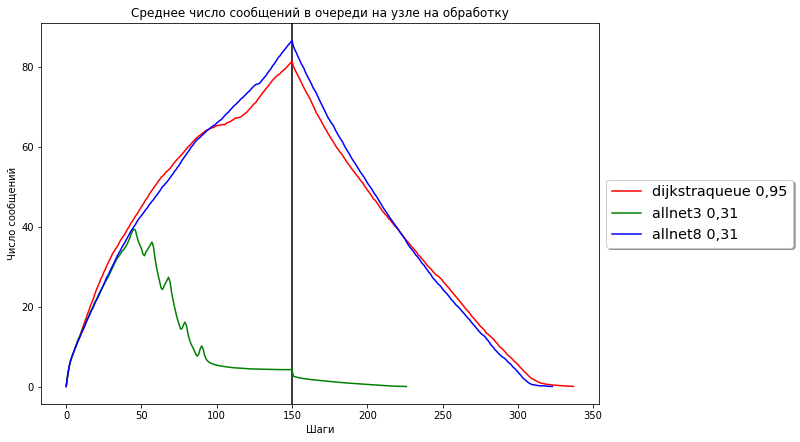

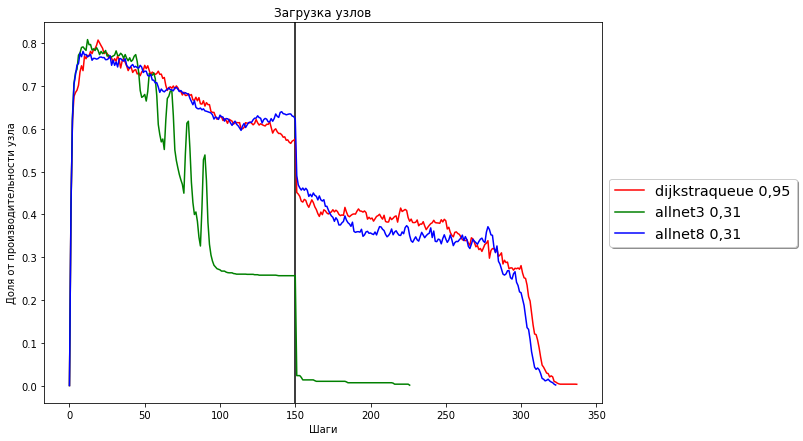

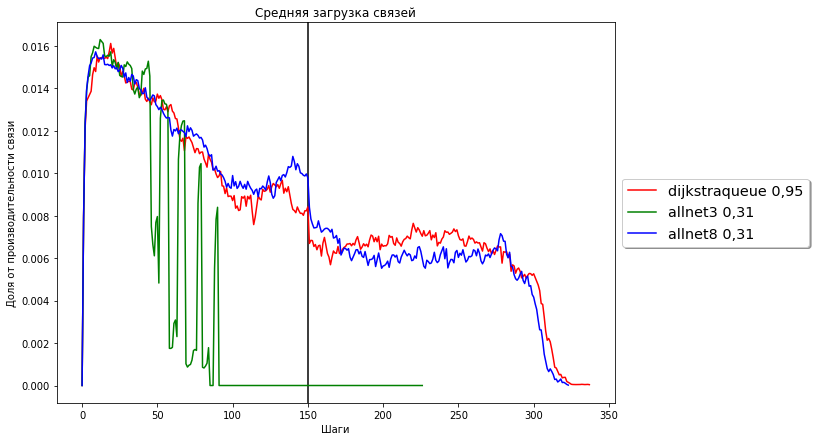

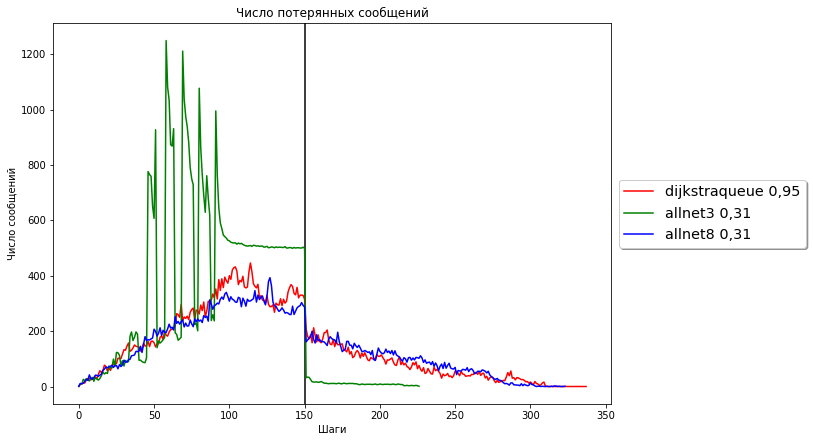

Доставлено 27373 Потеряно 63.5032% -dijkstraqueue 0,95
Доставлено 12026 Потеряно 83.9655% -allnet3 0,31
Доставлено 29298 Потеряно 60.9365% -allnet8 0,31


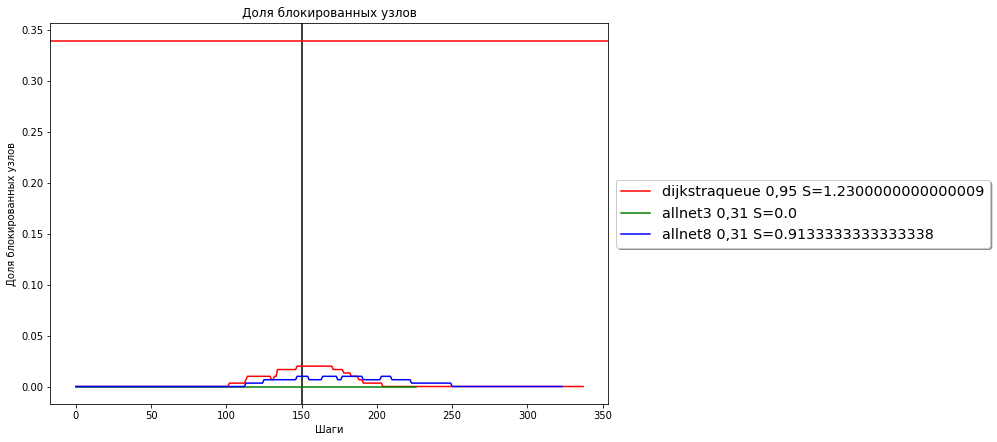

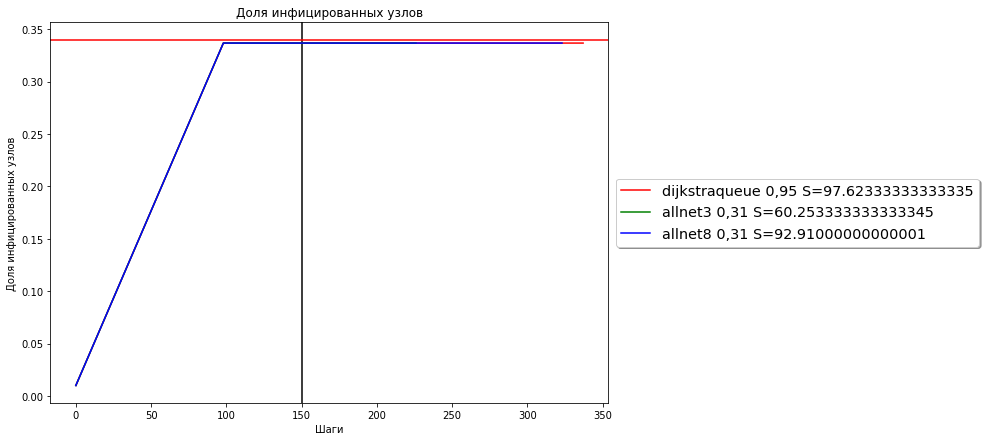

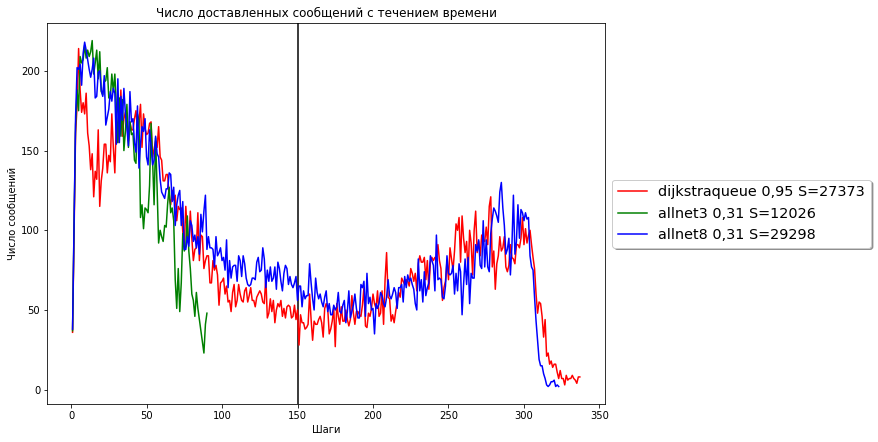

In [3]:
quantity = 500;
log_tags = [
{"tag":  "2a1d5c38-6382-4794-97a0-83a848863fac", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "a33530f9-11d4-4947-bfd4-363f8e4bbecb", "label": "allnet3 0,31", "color": "green"},
{"tag":  "699af38c-be73-4b60-8568-9475a9519c4b", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage(); 

<strong>Quantity 1000 </strong>

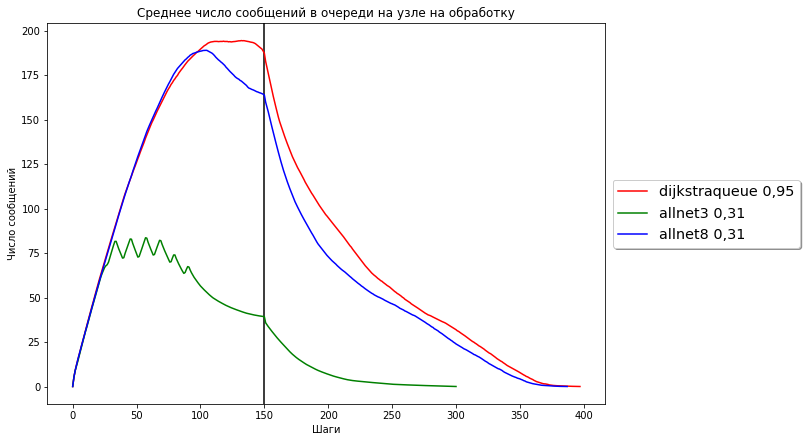

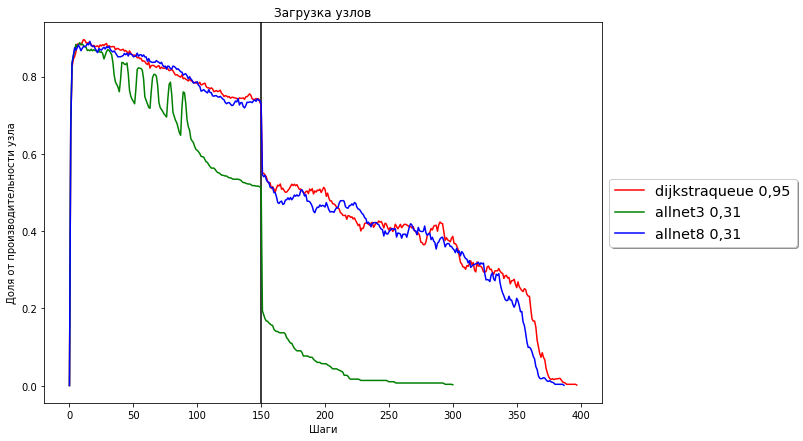

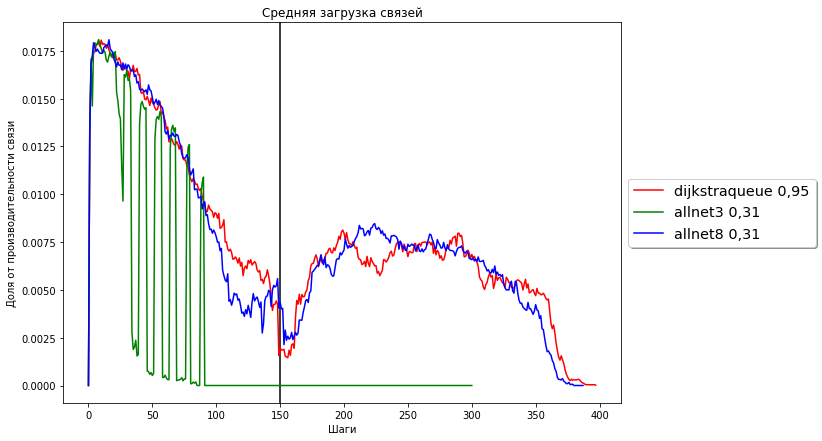

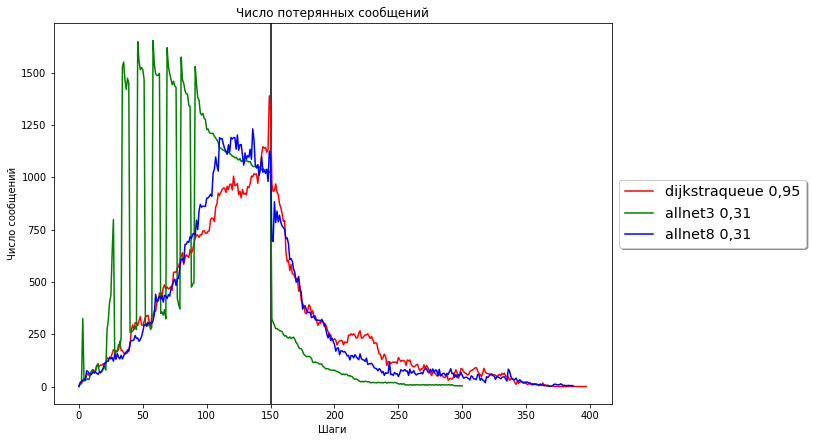

Доставлено 25777 Потеряно 82.8154% -dijkstraqueue 0,95
Доставлено 7060 Потеряно 95.2934% -allnet3 0,31
Доставлено 26070 Потеряно 82.6201% -allnet8 0,31


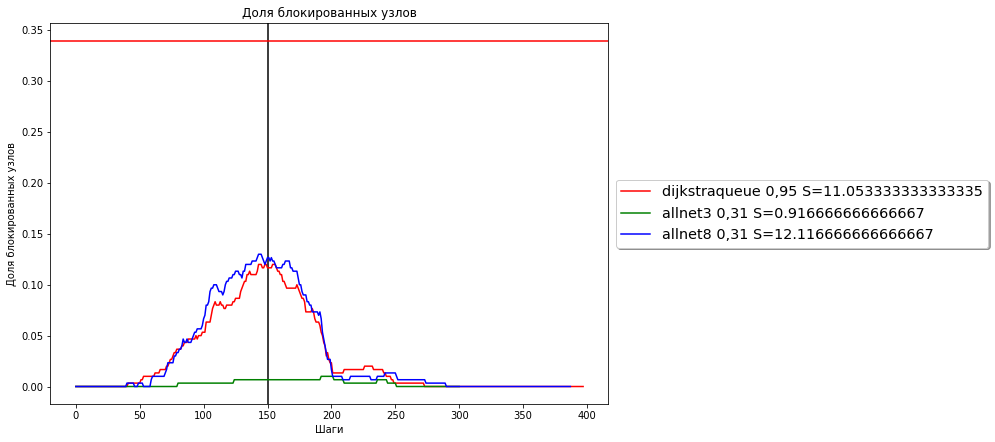

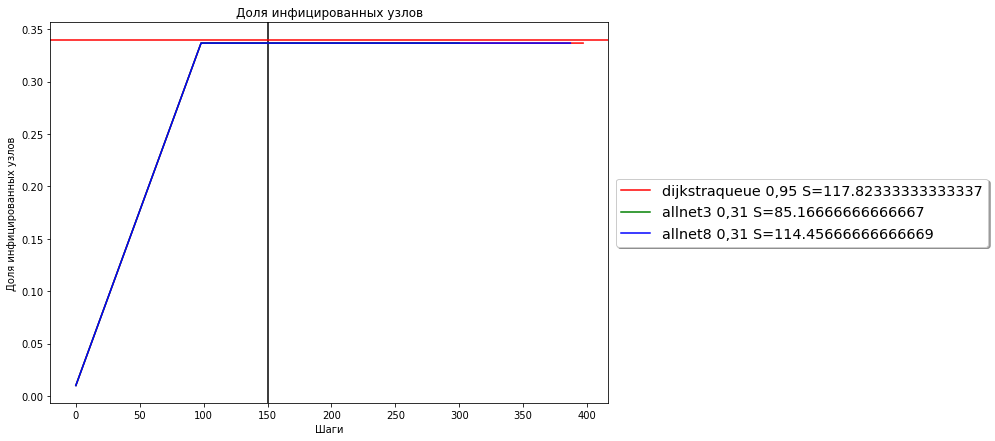

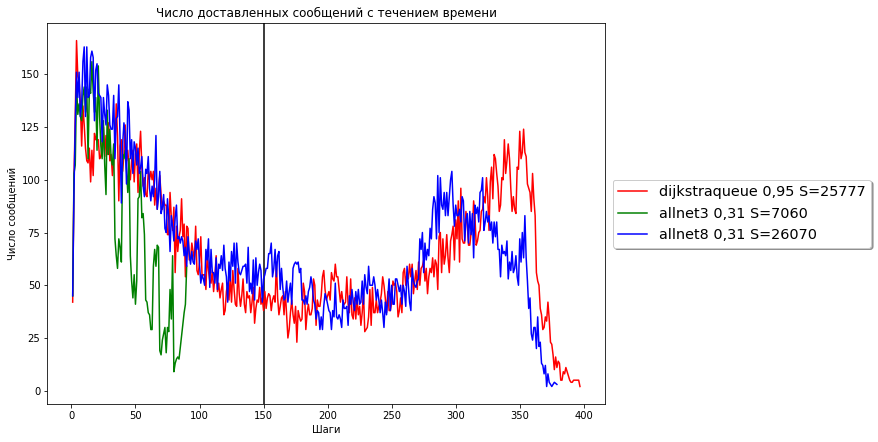

In [4]:
quantity = 1000;
log_tags = [
{"tag":  "be822b33-1fe9-44e3-a456-404020c0e639", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "86be9538-931a-4205-8da3-2d612a78b22b", "label": "allnet3 0,31", "color": "green"},
{"tag":  "d5d3c7db-73ee-4b43-8be7-f5ce0200a2a2", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

<strong>Quantity 1500 </strong>

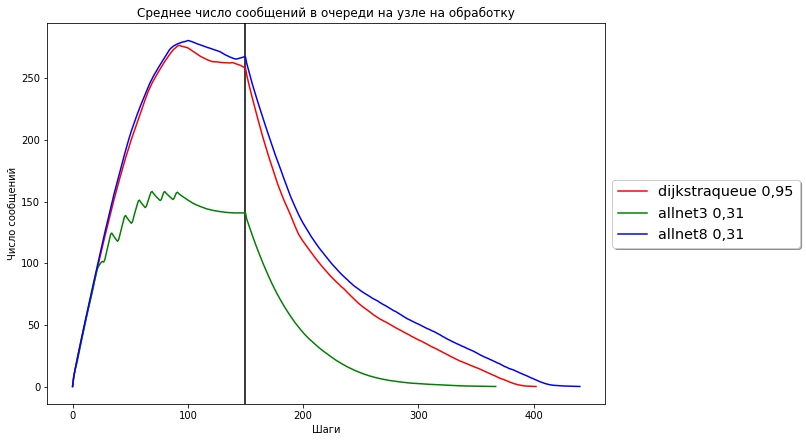

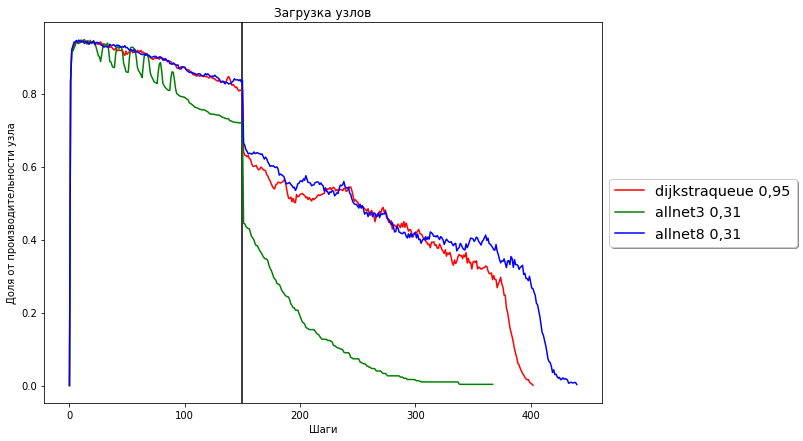

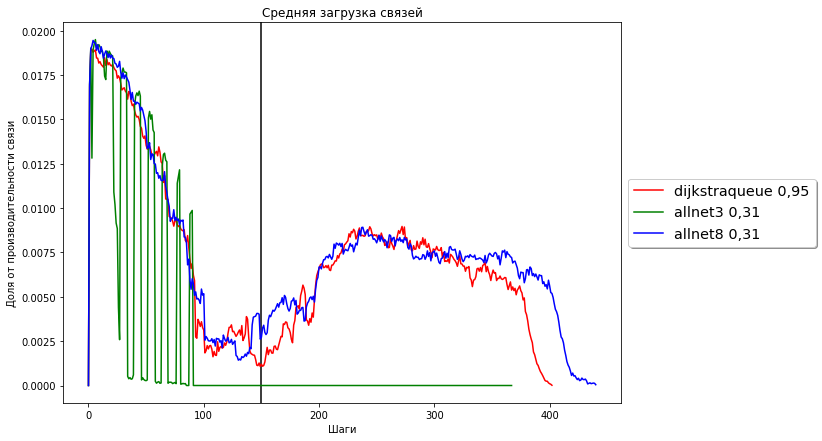

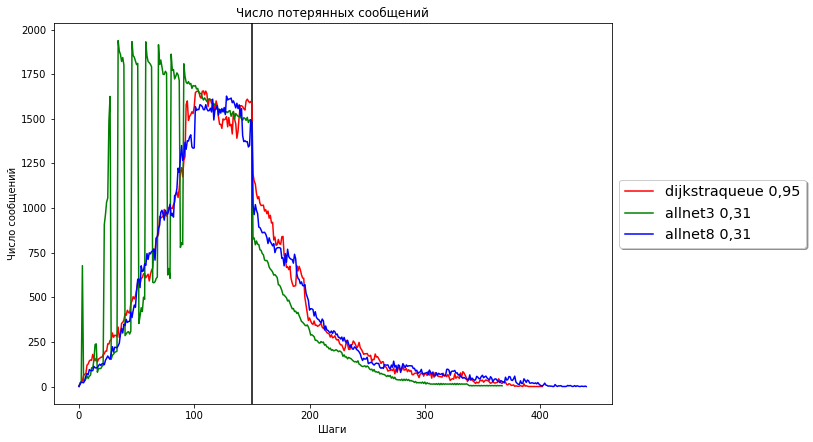

Доставлено 24113 Потеряно 89.2832% -dijkstraqueue 0,95
Доставлено 5268 Потеряно 97.6587% -allnet3 0,31
Доставлено 27116 Потеряно 87.9485% -allnet8 0,31


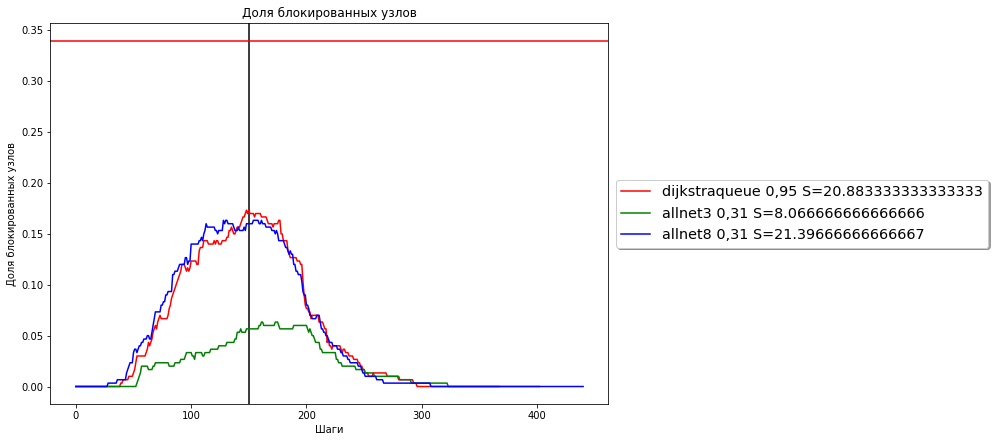

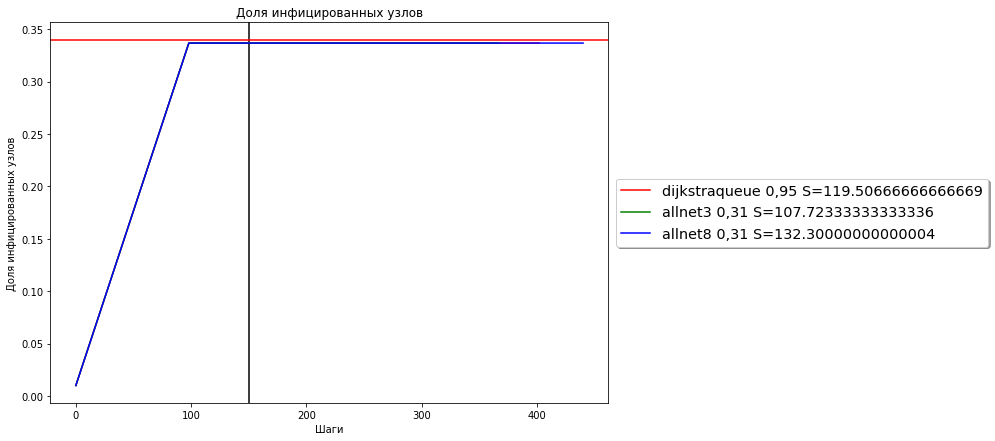

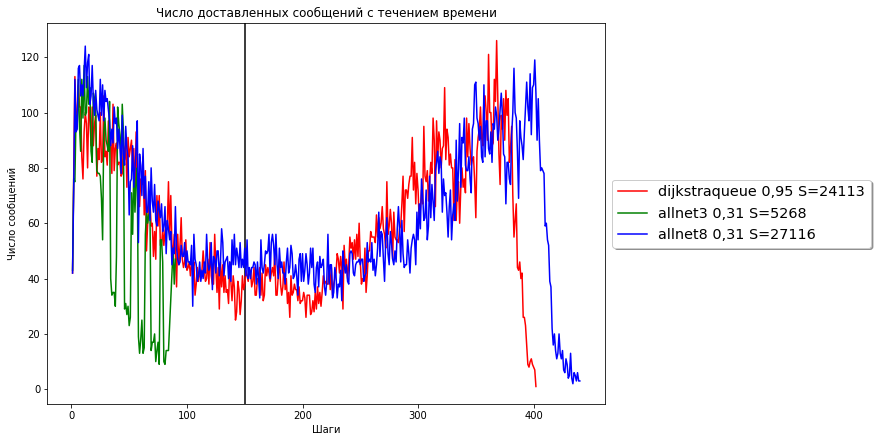

In [5]:
quantity = 1500;
log_tags = [
{"tag":  "b06052f5-2dbf-4a92-aaad-33458d541806", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "1b48c59a-fd5c-4466-b6fa-d3da7dbbfba1", "label": "allnet3 0,31", "color": "green"},
{"tag":  "c3bb89a6-3b26-49bc-83d6-ab76eef90ff8", "label": "allnet8 0,31", "color": "blue"},
]
showStat()
showStatBlocked();  
showStatMessage();

Доставлено 21566 Потеряно 52.0766% -dijkstraqueue 0,95
Доставлено 13428 Потеряно 70.1607% -allnet3 0,31
Доставлено 24852 Потеряно 44.7746% -allnet8 0,31


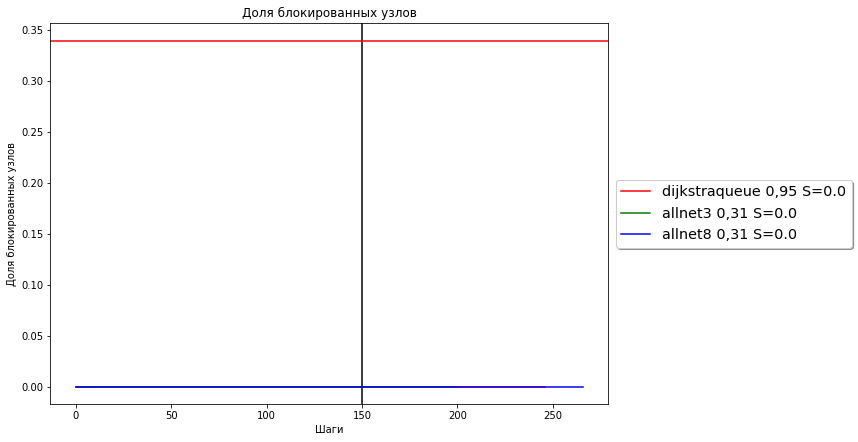

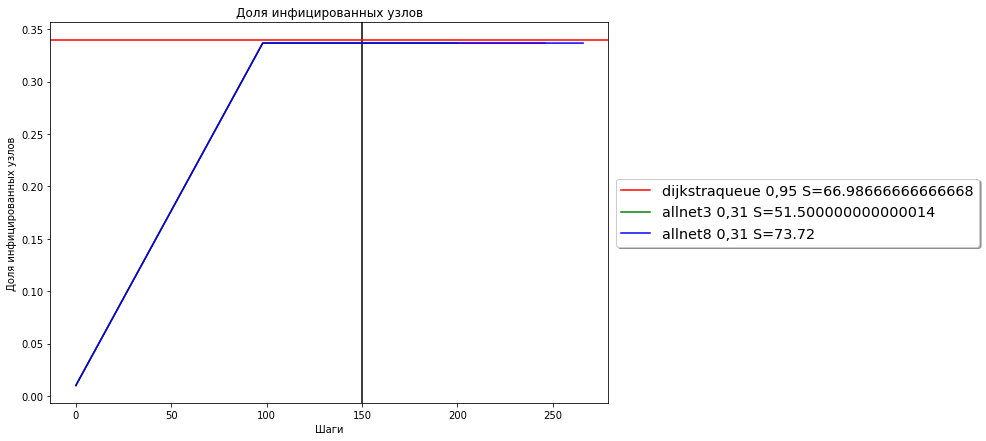

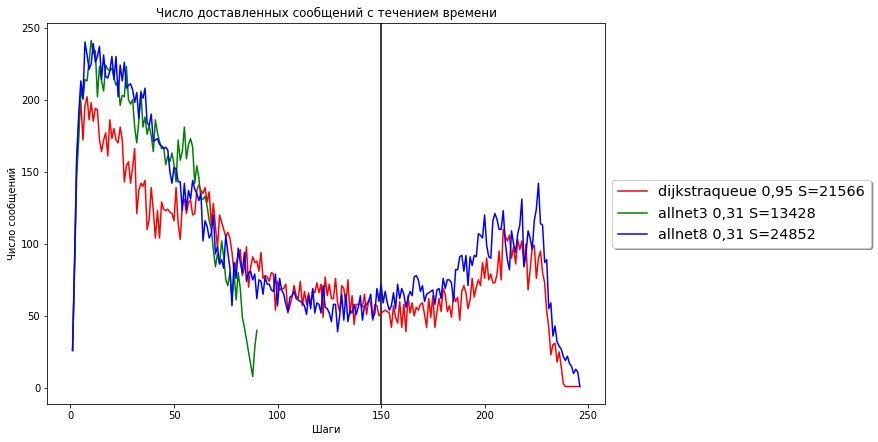

Доставлено 29072 Потеряно 72.3126% -dijkstraqueue 0,95
Доставлено 9493 Потеряно 90.9591% -allnet3 0,31
Доставлено 26600 Потеряно 74.6669% -allnet8 0,31


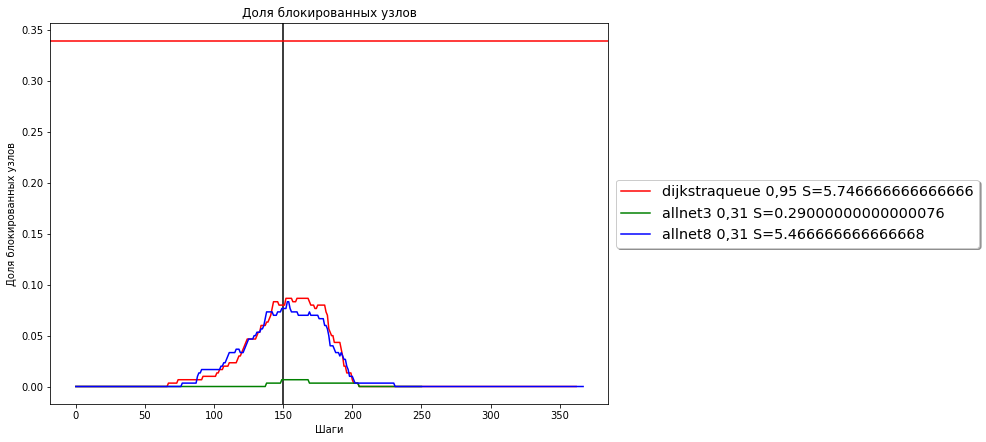

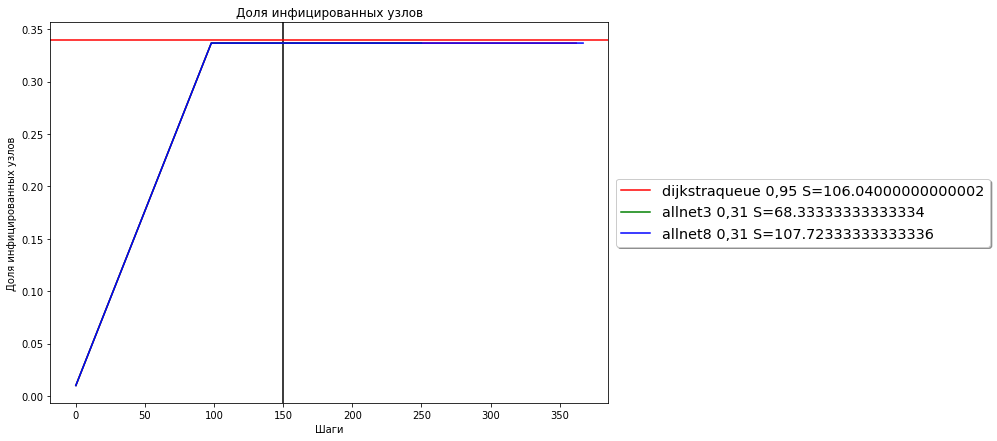

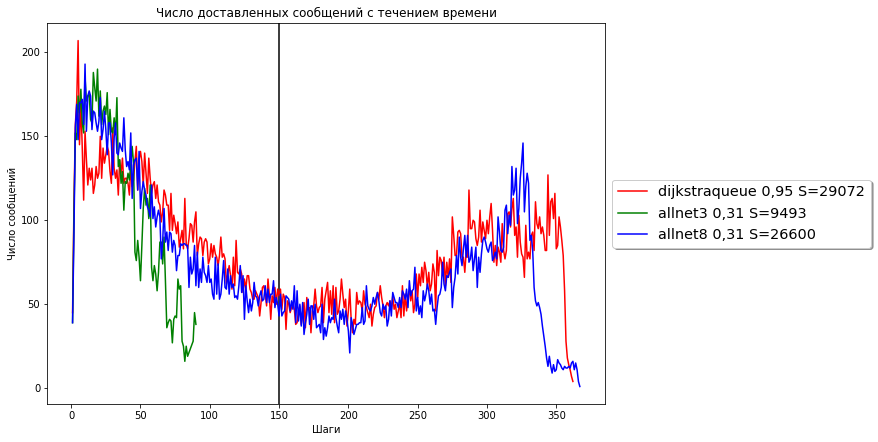

Доставлено 29197 Потеряно 78.3728% -dijkstraqueue 0,95
Доставлено 8026 Потеряно 94.0549% -allnet3 0,31
Доставлено 28058 Потеряно 79.2165% -allnet8 0,31


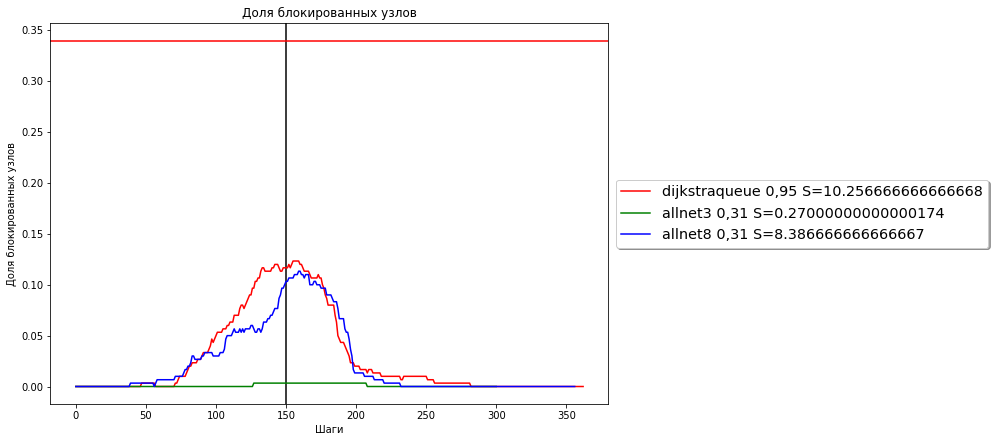

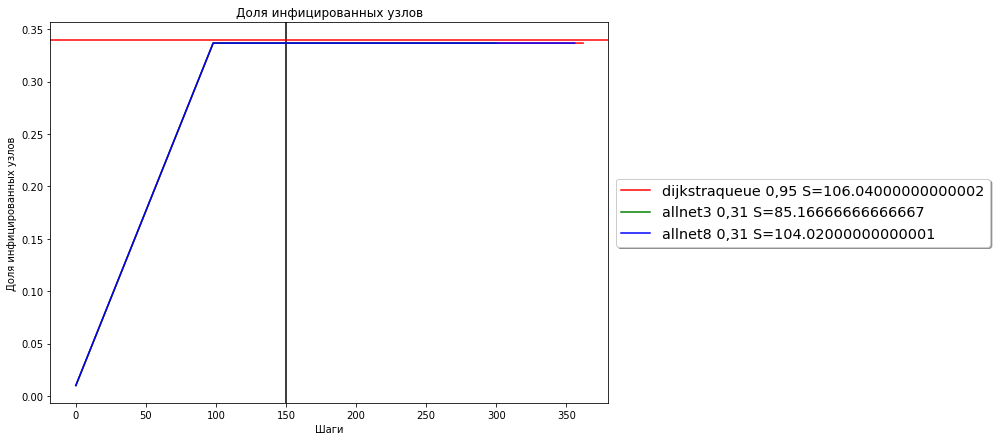

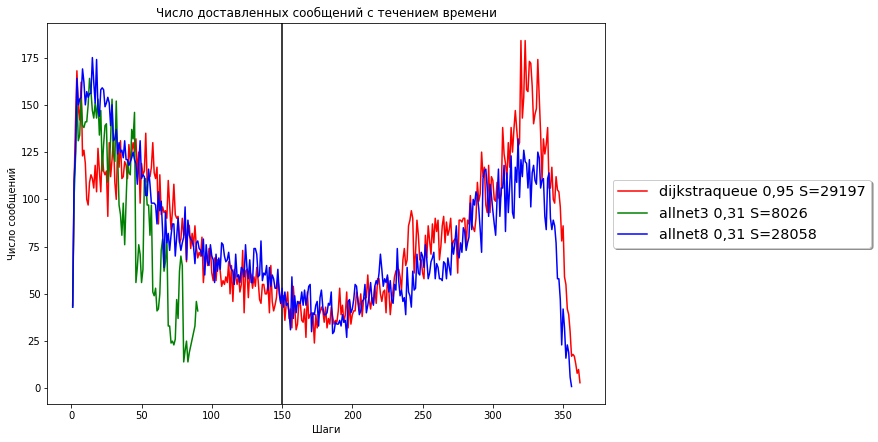

Доставлено 26654 Потеряно 86.3314% -dijkstraqueue 0,95
Доставлено 6177 Потеряно 96.8323% -allnet3 0,31
Доставлено 24635 Потеряно 87.3667% -allnet8 0,31


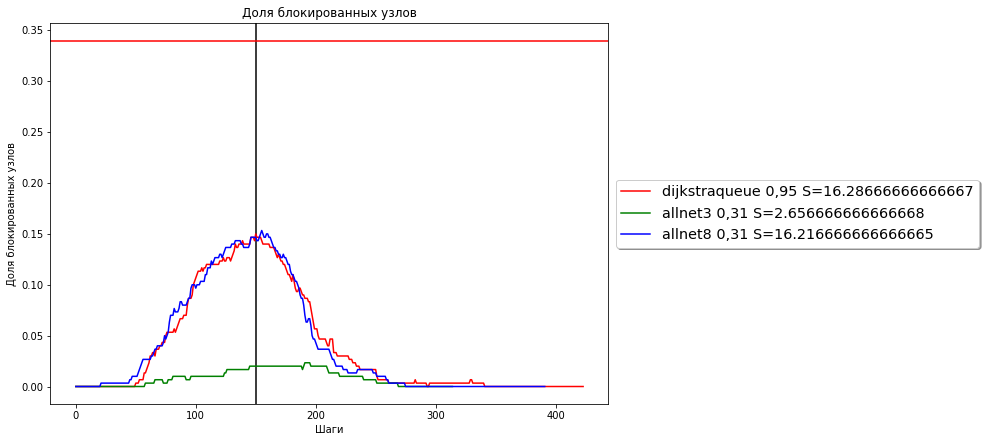

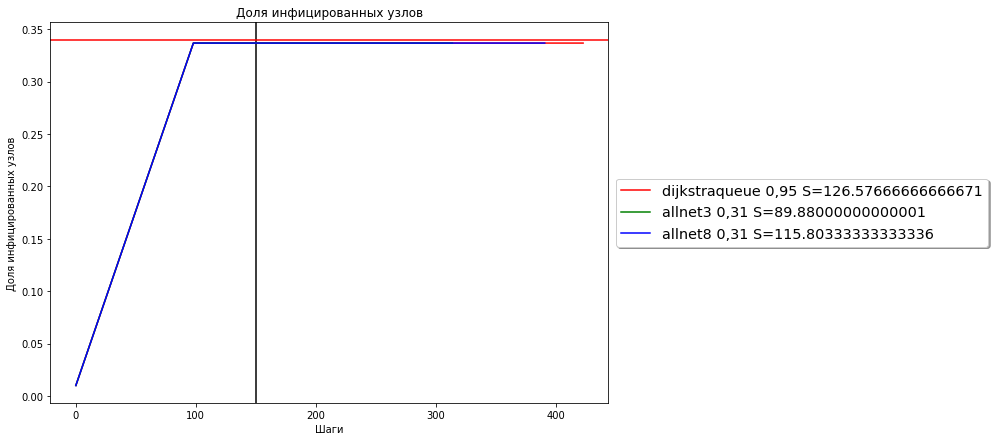

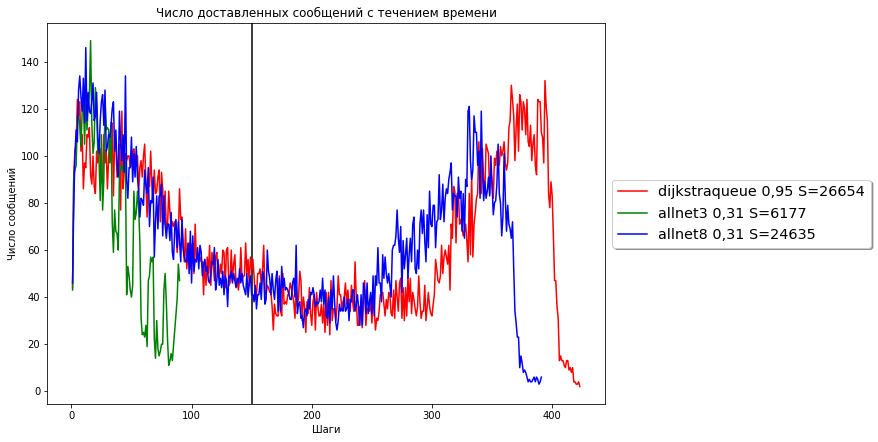

In [6]:
quantity = 300;
log_tags = [
{"tag":  "f95ad624-105b-4124-9af5-5f8becf9e545", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "acf02f21-08b2-4546-81aa-c782a57b0148", "label": "allnet3 0,31", "color": "green"},
{"tag":  "a1d1aeca-7c78-4ec9-bf1c-52c9d7d0f48e", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 700;
log_tags = [
{"tag":  "670286c9-5b3f-45c8-927e-077b1544e33d", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "47f1243e-e0c9-4786-a7ea-35ae97bf7ca9", "label": "allnet3 0,31", "color": "green"},
{"tag":  "8da32bd4-b8e0-4d46-9643-5cb9964eefd6", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 900;
log_tags = [
{"tag":  "c2b62d32-8d2c-4798-b784-446c5416f8f5", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "71df9592-cbb8-4154-a931-ba3e0edfc5c9", "label": "allnet3 0,31", "color": "green"},
{"tag":  "6d23d84d-2f75-4259-8f20-a6f4ded30f38", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

quantity = 1300;
log_tags = [
{"tag":  "b03e7323-9f0e-4da7-8d07-d66b3e707a32", "label": "dijkstraqueue 0,95", "color": "red"},
{"tag":  "44716464-0e75-4c37-8dcf-356aaf5c1500", "label": "allnet3 0,31", "color": "green"},
{"tag":  "e725d97e-c85e-472a-ad09-fa0fd95499e9", "label": "allnet8 0,31", "color": "blue"},
]
showStatBlocked();
showStatMessage();

      dijkstraqueue 0,95  allnet3 0,31  allnet8 0,31
100             3.250850      2.126725      2.986134
300            28.681340      5.321837     27.882136
500            52.927014      9.241610     53.207184
700            66.817668     12.936820     65.179732
900            70.200769     17.145621     63.318612
1000           68.232438     19.287798     61.761222
1300           70.038738     25.751986     62.638012
1500           64.165657     33.072635     69.337834


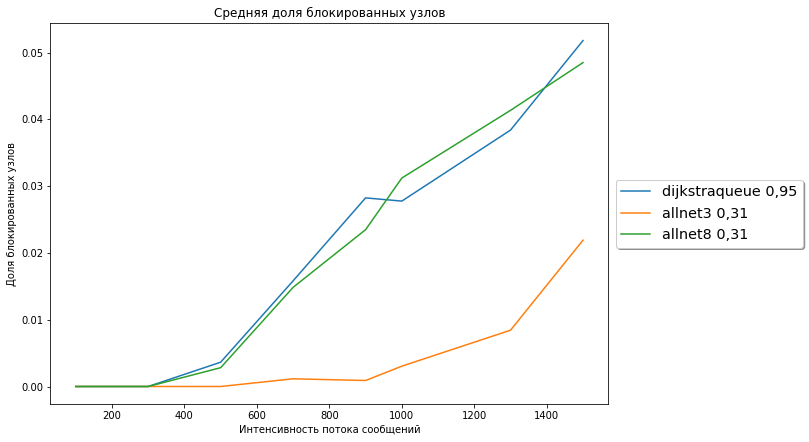

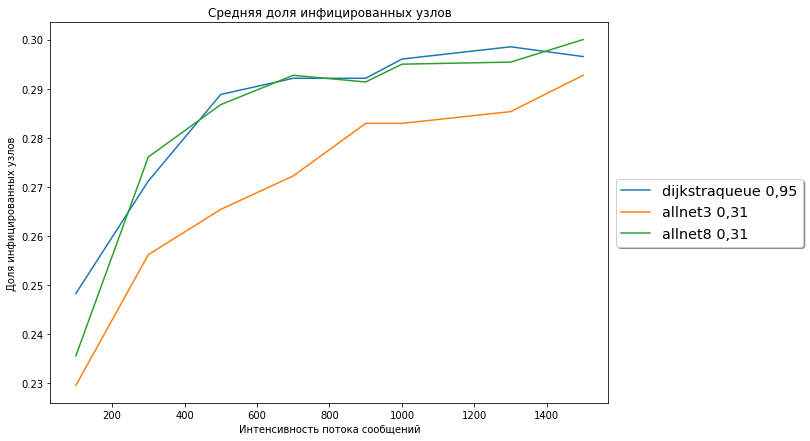

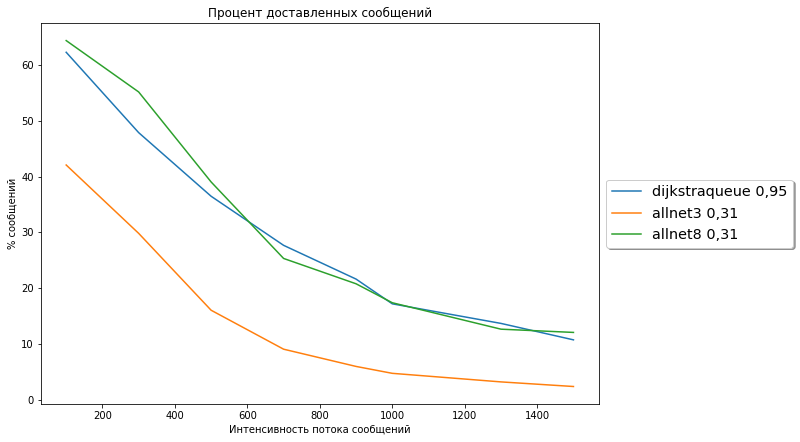

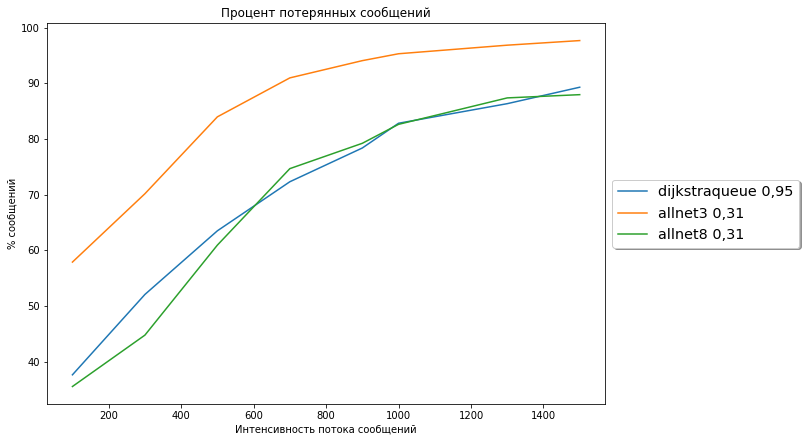

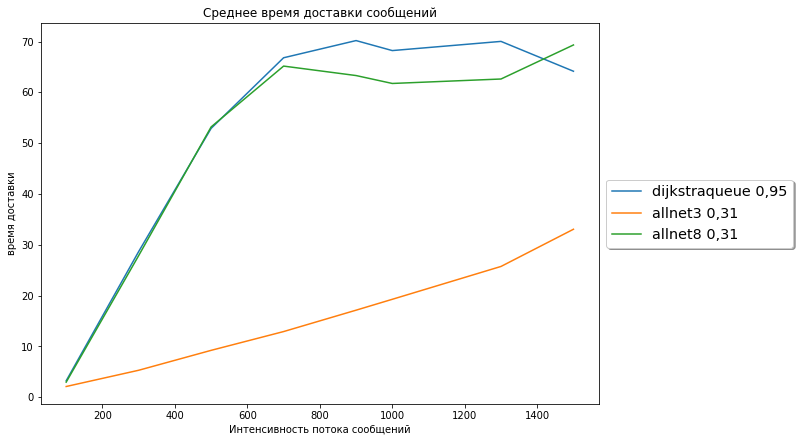

In [7]:
summBlocked.sort_index(inplace=True)
axs = summBlocked.plot()
axs.set_title("Средняя доля блокированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля блокированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

summInfected.sort_index(inplace=True)
axs = summInfected.plot()
axs.set_title("Средняя доля инфицированных узлов")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("Доля инфицированных узлов")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageResived.sort_index(inplace=True)
axs = MessageResived.plot()
axs.set_title("Процент доставленных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageFall.sort_index(inplace=True)
axs = MessageFall.plot()
axs.set_title("Процент потерянных сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("% сообщений")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()

MessageTimeSpent.sort_index(inplace=True)
axs = MessageTimeSpent.plot()
axs.set_title("Среднее время доставки сообщений")
axs.set_xlabel("Интенсивность потока сообщений")
axs.set_ylabel("время доставки")
legend = axs.legend(loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, fontsize='x-large')
legend.get_frame()
print (MessageTimeSpent)

In [8]:
print(summBlocked.mean().to_string())
print("")
print(MessageFall.mean().to_string())
print("")
print(MessageTimeSpent.mean().to_string())
print("")
print(summInfected.mean().to_string())

dijkstraqueue 0,95    0.020716
allnet3 0,31          0.004431
allnet8 0,31          0.020285

dijkstraqueue 0,95    70.293244
allnet3 0,31          85.851755
allnet8 0,31          69.135094

dijkstraqueue 0,95    53.039309
allnet3 0,31          15.610629
allnet8 0,31          50.788858

dijkstraqueue 0,95    0.285461
allnet3 0,31          0.270929
allnet8 0,31          0.284122
